In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Загрузка исходных данных из файла parquet
data_cleaned = pd.read_parquet('data/data_cleaned.parquet')
data_cleaned

,index,Наименование,Статус,Год,"Векселя, RUB","Вклады физических лиц, RUB","Депозиты юридических лиц, RUB","Капитал, RUB","Коррсчета (ЛОРО), RUB","Коррсчета (НОСТРО), RUB",...,"Прибыль (убыток) до налогообложения, RUB","Резервы на возможные потери, RUB","Средства клиентов, RUB","Средства организаций на расчетных счетах, RUB","Счета в Банке России, RUB","Учтённые векселя, RUB","Ценные бумаги, RUB","Чистые активы, RUB",Дата иска,Категориальная переменная
0,0,"1БАНК, ПАО АКБ",В состоянии банкротства,2012,0.0,1.226390e+08,3.000000e+06,1.927330e+08,11000.0,870000.0,...,10396000.0,1.828100e+07,1.807880e+08,5.514900e+07,3.680800e+07,0.0,0.0,4.205990e+08,2016-03-17,True
1,1,"1БАНК, ПАО АКБ",В состоянии банкротства,2013,0.0,5.059960e+08,2.300000e+07,2.019460e+08,11000.0,2934000.0,...,-14627000.0,5.649100e+07,7.288270e+08,1.998210e+08,1.768380e+08,0.0,0.0,1.003999e+09,2016-03-17,True
2,2,"1БАНК, ПАО АКБ",В состоянии банкротства,2014,0.0,6.765150e+08,6.550000e+07,3.809590e+08,11000.0,7380000.0,...,95218000.0,1.031700e+08,8.161780e+08,7.415900e+07,7.574100e+07,0.0,0.0,1.247518e+09,2016-03-17,True
3,3,"1БАНК, ПАО АКБ",В состоянии банкротства,2015,0.0,1.161053e+09,7.050000e+07,3.151290e+08,11000.0,22415000.0,...,-65925000.0,1.448710e+08,1.290838e+09,5.926800e+07,1.029940e+08,0.0,0.0,1.711006e+09,2016-03-17,True
4,4,"АБ ПУШКИНО, ОАО",В состоянии банкротства,2012,3157000.0,2.204129e+10,1.115042e+09,3.022102e+09,122793000.0,365146000.0,...,404035000.0,1.799256e+09,2.495356e+10,1.748636e+09,1.240221e+09,236580000.0,385983000.0,2.948222e+10,2013-11-26,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,4600,"ЯРИНТЕРБАНК (ООО), ИКБР",Действующая,2014,0.0,6.498620e+08,1.621180e+08,3.122630e+08,2327000.0,65014000.0,...,94131000.0,9.843900e+07,1.888023e+09,1.075964e+09,4.632250e+08,0.0,0.0,2.341448e+09,1970-01-01,False
4010,4601,"ЯРИНТЕРБАНК (ООО), ИКБР",Действующая,2015,646000.0,7.933810e+08,2.899130e+08,3.337730e+08,10000.0,89435000.0,...,46642000.0,1.127430e+08,1.822220e+09,7.369740e+08,4.817640e+08,0.0,0.0,2.338130e+09,1970-01-01,False
4011,4602,"ЯРИНТЕРБАНК (ООО), ИКБР",Действующая,2016,646000.0,7.996510e+08,1.827550e+08,3.360310e+08,0.0,37062000.0,...,4955000.0,1.015520e+08,1.652815e+09,6.703630e+08,3.082720e+08,0.0,0.0,2.132294e+09,1970-01-01,False
4012,4603,"ЯРИНТЕРБАНК (ООО), ИКБР",Действующая,2017,826000.0,7.166930e+08,5.863500e+07,3.616990e+08,0.0,51883000.0,...,38220000.0,1.039080e+08,1.476169e+09,7.007840e+08,3.627730e+08,0.0,0.0,1.991806e+09,1970-01-01,False


In [2]:

columns_to_drop = [
]
data_cleaned = data_cleaned.drop(columns=columns_to_drop)


# Список столбцов, для которых нужно рассчитать изменения в процентах за последний год
columns_to_calculate = [ ' Векселя, RUB',
                         ' Вклады физических лиц, RUB', ' Депозиты юридических лиц, RUB',
                         ' Капитал, RUB', ' Коррсчета (ЛОРО), RUB', ' Коррсчета (НОСТРО), RUB',
                         ' Коэффициент невозврата основной суммы долга, %',
                         ' Коэффициент обеспечения Кредитного портфеля, %',
                         ' Коэффициент покрытия Кредитного портфеля, %',
                         ' Коэффициент просроченной задолженности в Кредитном портфеле, %',
                         ' Кредиты другим банкам (МБК), RUB',
                         ' Кредиты других банков (МБК), RUB', ' Кредиты организациям, RUB',
                         ' Кредиты физическим лицам, RUB', ' Кредиты, RUB', ' Норматив Н1.0',
                         ' Норматив Н2', ' Норматив Н3', ' Норматив Н4', ' Облигации, RUB',
                         ' Основные средства, RUB', ' Прибыль (убыток) до налогообложения, RUB',
                         ' Резервы на возможные потери, RUB', ' Средства клиентов, RUB',
                         ' Средства организаций на расчетных счетах, RUB',
                         ' Счета в Банке России, RUB', ' Учтённые векселя, RUB',
                         ' Ценные бумаги, RUB', ' Чистые активы, RUB',]

# Выбор последних двух годов для каждой компании
last_years_data = data_cleaned.groupby('Наименование').apply(lambda x: x.nlargest(2, 'Год')).reset_index(drop=True)

def calculate_percentage_change(df, columns, years):
    if len(df) < years:
        return pd.Series([float('NaN')] * len(columns), index=columns)
    changes = (df.iloc[years-1][columns] - df.iloc[0][columns]) / df.iloc[0][columns] * 100
    return changes

# Вычисление изменений в процентах за последние 2 и 3 года для указанных столбцов
last_2_years_changes = data_cleaned.groupby('Наименование').apply(calculate_percentage_change, columns=columns_to_calculate, years=2)
last_3_years_changes = data_cleaned.groupby('Наименование').apply(calculate_percentage_change, columns=columns_to_calculate, years=3)
last_4_years_changes = data_cleaned.groupby('Наименование').apply(calculate_percentage_change, columns=columns_to_calculate, years=4)

# Замена пропусков на нули
last_2_years_changes = last_2_years_changes.fillna(0)
last_3_years_changes = last_3_years_changes.fillna(0)
last_4_years_changes = last_4_years_changes.fillna(0)
# Переименование столбцов
last_2_years_changes.columns = [col + '_change_last_2_years' for col in last_2_years_changes.columns]
last_3_years_changes.columns = [col + '_change_last_3_years' for col in last_3_years_changes.columns]
last_4_years_changes.columns = [col + '_change_last_4_years' for col in last_4_years_changes.columns]


# Объединение информации об изменениях с исходным датафреймом
data_cleaned = pd.merge(data_cleaned, last_2_years_changes, on='Наименование', how='left')
data_cleaned = pd.merge(data_cleaned, last_3_years_changes, on='Наименование', how='left')
data_cleaned = pd.merge(data_cleaned, last_4_years_changes, on='Наименование', how='left')
# Вывод результата
data_cleaned


,index,Наименование,Статус,Год,"Векселя, RUB","Вклады физических лиц, RUB","Депозиты юридических лиц, RUB","Капитал, RUB","Коррсчета (ЛОРО), RUB","Коррсчета (НОСТРО), RUB",...,"Облигации, RUB_change_last_4_years","Основные средства, RUB_change_last_4_years","Прибыль (убыток) до налогообложения, RUB_change_last_4_years","Резервы на возможные потери, RUB_change_last_4_years","Средства клиентов, RUB_change_last_4_years","Средства организаций на расчетных счетах, RUB_change_last_4_years","Счета в Банке России, RUB_change_last_4_years","Учтённые векселя, RUB_change_last_4_years","Ценные бумаги, RUB_change_last_4_years","Чистые активы, RUB_change_last_4_years"
0,0,"1БАНК, ПАО АКБ",В состоянии банкротства,2012,0.0,1.226390e+08,3.000000e+06,1.927330e+08,11000.0,870000.0,...,0.0,359.58098,-734.138130,692.467589,614.006461,7.468857,179.814171,0.0,0.0,306.802204
1,1,"1БАНК, ПАО АКБ",В состоянии банкротства,2013,0.0,5.059960e+08,2.300000e+07,2.019460e+08,11000.0,2934000.0,...,0.0,359.58098,-734.138130,692.467589,614.006461,7.468857,179.814171,0.0,0.0,306.802204
2,2,"1БАНК, ПАО АКБ",В состоянии банкротства,2014,0.0,6.765150e+08,6.550000e+07,3.809590e+08,11000.0,7380000.0,...,0.0,359.58098,-734.138130,692.467589,614.006461,7.468857,179.814171,0.0,0.0,306.802204
3,3,"1БАНК, ПАО АКБ",В состоянии банкротства,2015,0.0,1.161053e+09,7.050000e+07,3.151290e+08,11000.0,22415000.0,...,0.0,359.58098,-734.138130,692.467589,614.006461,7.468857,179.814171,0.0,0.0,306.802204
4,4,"АБ ПУШКИНО, ОАО",В состоянии банкротства,2012,3157000.0,2.204129e+10,1.115042e+09,3.022102e+09,122793000.0,365146000.0,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,4600,"ЯРИНТЕРБАНК (ООО), ИКБР",Действующая,2014,0.0,6.498620e+08,1.621180e+08,3.122630e+08,2327000.0,65014000.0,...,0.0,-7.81658,-10.085978,20.932552,-5.757364,-31.341131,-10.733695,0.0,0.0,1.558520
4010,4601,"ЯРИНТЕРБАНК (ООО), ИКБР",Действующая,2015,646000.0,7.933810e+08,2.899130e+08,3.337730e+08,10000.0,89435000.0,...,0.0,-7.81658,-10.085978,20.932552,-5.757364,-31.341131,-10.733695,0.0,0.0,1.558520
4011,4602,"ЯРИНТЕРБАНК (ООО), ИКБР",Действующая,2016,646000.0,7.996510e+08,1.827550e+08,3.360310e+08,0.0,37062000.0,...,0.0,-7.81658,-10.085978,20.932552,-5.757364,-31.341131,-10.733695,0.0,0.0,1.558520
4012,4603,"ЯРИНТЕРБАНК (ООО), ИКБР",Действующая,2017,826000.0,7.166930e+08,5.863500e+07,3.616990e+08,0.0,51883000.0,...,0.0,-7.81658,-10.085978,20.932552,-5.757364,-31.341131,-10.733695,0.0,0.0,1.558520


In [3]:
# Фильтруем данные по категориальной переменной
bankrupt_data = data_cleaned[data_cleaned['Категориальная переменная'] == True]
no_bankrupt_data = data_cleaned[data_cleaned['Категориальная переменная'] == False]

# Приводим столбец 'Год' в тип int для компаний
no_bankrupt_data['Год'] = no_bankrupt_data['Год'].astype(int)
bankrupt_data['Год'] = bankrupt_data['Год'].astype(int)
no_bankrupt_data

C:\Users\User\AppData\Local\Temp\ipykernel_17776\58335180.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_bankrupt_data['Год'] = no_bankrupt_data['Год'].astype(int)
C:\Users\User\AppData\Local\Temp\ipykernel_17776\58335180.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankrupt_data['Год'] = bankrupt_data['Год'].astype(int)


,index,Наименование,Статус,Год,"Векселя, RUB","Вклады физических лиц, RUB","Депозиты юридических лиц, RUB","Капитал, RUB","Коррсчета (ЛОРО), RUB","Коррсчета (НОСТРО), RUB",...,"Облигации, RUB_change_last_4_years","Основные средства, RUB_change_last_4_years","Прибыль (убыток) до налогообложения, RUB_change_last_4_years","Резервы на возможные потери, RUB_change_last_4_years","Средства клиентов, RUB_change_last_4_years","Средства организаций на расчетных счетах, RUB_change_last_4_years","Счета в Банке России, RUB_change_last_4_years","Учтённые векселя, RUB_change_last_4_years","Ценные бумаги, RUB_change_last_4_years","Чистые активы, RUB_change_last_4_years"
5,6,"АБ РОССИЯ, АО",Действующая,2012,7.577667e+09,3.158681e+10,9.694462e+10,3.249666e+10,3215000.0,4.227721e+10,...,0.0,70.678302,-12.539769,159.961433,92.180800,56.783341,-36.770705,-89.128043,120.909108,81.894555
6,7,"АБ РОССИЯ, АО",Действующая,2013,7.774365e+09,3.669646e+10,1.709687e+11,4.538961e+10,62183000.0,4.185877e+10,...,0.0,70.678302,-12.539769,159.961433,92.180800,56.783341,-36.770705,-89.128043,120.909108,81.894555
7,8,"АБ РОССИЯ, АО",Действующая,2014,2.918886e+09,3.111039e+10,1.843940e+11,5.342292e+10,30120000.0,1.264731e+10,...,0.0,70.678302,-12.539769,159.961433,92.180800,56.783341,-36.770705,-89.128043,120.909108,81.894555
8,9,"АБ РОССИЯ, АО",Действующая,2015,2.672451e+09,4.272068e+10,2.528024e+11,5.723851e+10,1156000.0,2.212305e+10,...,0.0,70.678302,-12.539769,159.961433,92.180800,56.783341,-36.770705,-89.128043,120.909108,81.894555
9,10,"АБ РОССИЯ, АО",Действующая,2016,3.155582e+09,5.695791e+10,3.110246e+11,7.186344e+10,10334000.0,1.482420e+10,...,0.0,70.678302,-12.539769,159.961433,92.180800,56.783341,-36.770705,-89.128043,120.909108,81.894555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,4600,"ЯРИНТЕРБАНК (ООО), ИКБР",Действующая,2014,0.000000e+00,6.498620e+08,1.621180e+08,3.122630e+08,2327000.0,6.501400e+07,...,0.0,-7.816580,-10.085978,20.932552,-5.757364,-31.341131,-10.733695,0.000000,0.000000,1.558520
4010,4601,"ЯРИНТЕРБАНК (ООО), ИКБР",Действующая,2015,6.460000e+05,7.933810e+08,2.899130e+08,3.337730e+08,10000.0,8.943500e+07,...,0.0,-7.816580,-10.085978,20.932552,-5.757364,-31.341131,-10.733695,0.000000,0.000000,1.558520
4011,4602,"ЯРИНТЕРБАНК (ООО), ИКБР",Действующая,2016,6.460000e+05,7.996510e+08,1.827550e+08,3.360310e+08,0.0,3.706200e+07,...,0.0,-7.816580,-10.085978,20.932552,-5.757364,-31.341131,-10.733695,0.000000,0.000000,1.558520
4012,4603,"ЯРИНТЕРБАНК (ООО), ИКБР",Действующая,2017,8.260000e+05,7.166930e+08,5.863500e+07,3.616990e+08,0.0,5.188300e+07,...,0.0,-7.816580,-10.085978,20.932552,-5.757364,-31.341131,-10.733695,0.000000,0.000000,1.558520


In [4]:
# Вычисляем год иска для компаний, которые банкроты
bankrupt_data['Год иска'] = bankrupt_data['Дата иска'].apply(lambda x: x.year - 2 if x.month > 3 else x.year - 1)

# Фильтруем банкроты по году
filtered_data = bankrupt_data[bankrupt_data['Год'] == bankrupt_data['Год иска']]
filtered_data

C:\Users\User\AppData\Local\Temp\ipykernel_17776\919790913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankrupt_data['Год иска'] = bankrupt_data['Дата иска'].apply(lambda x: x.year - 2 if x.month > 3 else x.year - 1)


,index,Наименование,Статус,Год,"Векселя, RUB","Вклады физических лиц, RUB","Депозиты юридических лиц, RUB","Капитал, RUB","Коррсчета (ЛОРО), RUB","Коррсчета (НОСТРО), RUB",...,"Основные средства, RUB_change_last_4_years","Прибыль (убыток) до налогообложения, RUB_change_last_4_years","Резервы на возможные потери, RUB_change_last_4_years","Средства клиентов, RUB_change_last_4_years","Средства организаций на расчетных счетах, RUB_change_last_4_years","Счета в Банке России, RUB_change_last_4_years","Учтённые векселя, RUB_change_last_4_years","Ценные бумаги, RUB_change_last_4_years","Чистые активы, RUB_change_last_4_years",Год иска
3,3,"1БАНК, ПАО АКБ",В состоянии банкротства,2015,0.000000e+00,1.161053e+09,7.050000e+07,3.151290e+08,11000.0,2.241500e+07,...,359.580980,-734.138130,692.467589,614.006461,7.468857,179.814171,0.0,0.000000,306.802204,2015
75,87,"АГРОИНКОМБАНК, ПАО",В состоянии банкротства,2013,0.000000e+00,2.766470e+08,5.214000e+07,3.091250e+08,26000.0,1.054200e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2013
91,103,"АГРОСОЮЗ, ООО КБ",В состоянии банкротства,2016,8.937500e+07,7.720531e+09,2.368250e+08,1.236627e+09,50000.0,9.584400e+07,...,-44.612532,18.149927,355.143798,72.007957,10.128361,201.339263,0.0,747.450854,80.495438,2016
94,106,"АДМИРАЛТЕЙСКИЙ, ООО КБ",В состоянии банкротства,2013,3.308100e+07,2.744296e+09,5.488800e+08,1.137238e+09,29289000.0,1.529980e+08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2013
118,130,"АЙМАНИБАНК, ООО КБ",В состоянии банкротства,2014,2.313360e+08,1.619026e+10,4.719450e+08,2.728815e+09,416504000.0,1.478332e+09,...,-25.800870,-101.648105,227.883308,95.484774,-94.731908,-13.707764,-100.0,-6.720365,94.493353,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,4490,"ЭНЕРГОМАШБАНК, ПАО",В состоянии банкротства,2019,2.500000e+05,6.090788e+09,9.633070e+08,1.612335e+09,0.0,6.442390e+08,...,-7.738455,-67.061394,81.760895,-46.063720,-70.911140,94.976426,-100.0,-100.000000,-35.949708,2019
3933,4512,"ЭРГОБАНК, ООО КБ",В состоянии банкротства,2015,0.000000e+00,3.201715e+09,3.010000e+05,-7.837160e+08,0.0,1.227500e+07,...,77.070607,-8313.259354,11774.284044,64.622027,-96.021713,-43.403345,0.0,-99.998696,33.028094,2015
3965,4546,"ЮГРА, ПАО БАНК",В состоянии банкротства,2015,3.163354e+10,1.583675e+11,4.906242e+10,6.251114e+10,8000.0,3.808658e+09,...,42.948865,5609.352643,9985.243550,2521.379611,187.001794,347.986928,0.0,6624.616694,3708.760166,2015
3975,4565,"ЮМК БАНК, ООО",В состоянии банкротства,2020,0.000000e+00,0.000000e+00,1.000500e+09,2.167985e+09,0.0,1.910891e+09,...,-28.845591,344.327811,700.273745,181.269742,-6.362384,-61.101659,0.0,0.000000,161.565428,2020


In [5]:
# Сортировка данных по столбцам "наименование" и "год"
sorted_data = no_bankrupt_data.sort_values(by=['Наименование', 'Год'])

# Группировка данных по столбцу "наименование" и выбор последней строки из каждой группы
last_year_data = sorted_data.groupby('Наименование').tail(1)
last_year_data

,index,Наименование,Статус,Год,"Векселя, RUB","Вклады физических лиц, RUB","Депозиты юридических лиц, RUB","Капитал, RUB","Коррсчета (ЛОРО), RUB","Коррсчета (НОСТРО), RUB",...,"Облигации, RUB_change_last_4_years","Основные средства, RUB_change_last_4_years","Прибыль (убыток) до налогообложения, RUB_change_last_4_years","Резервы на возможные потери, RUB_change_last_4_years","Средства клиентов, RUB_change_last_4_years","Средства организаций на расчетных счетах, RUB_change_last_4_years","Счета в Банке России, RUB_change_last_4_years","Учтённые векселя, RUB_change_last_4_years","Ценные бумаги, RUB_change_last_4_years","Чистые активы, RUB_change_last_4_years"
14,15,"АБ РОССИЯ, АО",Действующая,2021,4.690733e+09,1.767977e+11,4.754062e+11,1.143235e+11,2.964000e+07,1.586745e+10,...,0.000000,70.678302,-12.539769,159.961433,92.180800,56.783341,-36.770705,-89.128043,120.909108,81.894555
24,25,"АБСОЛЮТ БАНК (ПАО), АКБ",Действующая,2021,2.128916e+09,1.095546e+11,4.254591e+10,3.280240e+10,1.162680e+08,1.186887e+09,...,25.647296,-26.625656,-214.018120,65.710816,283.116621,150.799016,3.766321,-100.000000,693.154171,171.688668
34,35,"АВАНГАРД, ПАО АКБ",Действующая,2021,1.922090e+09,3.576942e+10,1.310494e+10,2.093541e+10,1.474000e+06,3.165194e+09,...,-46.309531,29.546764,37.058763,124.520120,48.774614,4.160594,188.988195,-100.000000,35.293749,28.296824
44,45,"АВЕРС, АО БАНК",Действующая,2021,3.715000e+06,6.327966e+10,3.351195e+10,2.522423e+10,0.000000e+00,3.024527e+09,...,0.000000,19.922281,287.754086,1339.259533,211.215512,143.946369,131.659366,-35.562057,326.806112,169.315820
53,55,"АВТО ФИНАНС БАНК, АО",Действующая,2021,0.000000e+00,2.789193e+09,2.896895e+09,2.707109e+10,0.000000e+00,8.329500e+07,...,inf,1413.661524,-1506.229463,157336.884584,405129.310345,0.000000,2375.545596,0.000000,inf,915.761986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,4542,ЮГ-ИНВЕСТБАНК (ПАО),Действующая,2021,0.000000e+00,7.248602e+09,3.074130e+08,1.621278e+09,1.173100e+07,1.347890e+08,...,0.000000,40.200449,37.894945,36.374652,32.111309,-16.183755,-15.337186,0.000000,65.715114,35.248997
3987,4577,"ЮНИКРЕДИТ БАНК, АО",Действующая,2021,0.000000e+00,2.846647e+11,4.139051e+11,2.112663e+11,9.365559e+09,2.826679e+10,...,-18.362123,38.859513,-61.299187,191.438495,84.398600,71.451139,-76.463642,-100.000000,38.506333,61.169820
3997,4587,"ЮНИСТРИМ, АО КБ",Действующая,2021,0.000000e+00,0.000000e+00,7.671800e+07,1.059683e+09,4.211880e+08,6.576350e+08,...,0.000000,49.474642,-32.513043,26.527909,476.221801,859743.589744,35.141087,0.000000,0.000000,59.266402
4006,4596,"ЯНДЕКС БАНК, АО",Действующая,2020,0.000000e+00,3.218300e+07,1.984510e+08,1.001840e+09,0.000000e+00,1.268600e+07,...,0.000000,83.158484,-36.128905,134.861111,-52.718285,-79.823262,-27.934795,-100.000000,-98.862119,-26.978053


In [6]:
no_matched_data = pd.concat([last_year_data, filtered_data], ignore_index=True)

no_matched_data.to_parquet('data/no_matched_data.parquet')

# Save the matching_data DataFrame as an Excel file
no_matched_data.to_excel('data/no_matched_data.xlsx', index=False)
no_matched_data

,index,Наименование,Статус,Год,"Векселя, RUB","Вклады физических лиц, RUB","Депозиты юридических лиц, RUB","Капитал, RUB","Коррсчета (ЛОРО), RUB","Коррсчета (НОСТРО), RUB",...,"Основные средства, RUB_change_last_4_years","Прибыль (убыток) до налогообложения, RUB_change_last_4_years","Резервы на возможные потери, RUB_change_last_4_years","Средства клиентов, RUB_change_last_4_years","Средства организаций на расчетных счетах, RUB_change_last_4_years","Счета в Банке России, RUB_change_last_4_years","Учтённые векселя, RUB_change_last_4_years","Ценные бумаги, RUB_change_last_4_years","Чистые активы, RUB_change_last_4_years",Год иска
0,15,"АБ РОССИЯ, АО",Действующая,2021,4.690733e+09,1.767977e+11,4.754062e+11,1.143235e+11,29640000.0,1.586745e+10,...,70.678302,-12.539769,159.961433,92.180800,56.783341,-36.770705,-89.128043,120.909108,81.894555,NaN
1,25,"АБСОЛЮТ БАНК (ПАО), АКБ",Действующая,2021,2.128916e+09,1.095546e+11,4.254591e+10,3.280240e+10,116268000.0,1.186887e+09,...,-26.625656,-214.018120,65.710816,283.116621,150.799016,3.766321,-100.000000,693.154171,171.688668,NaN
2,35,"АВАНГАРД, ПАО АКБ",Действующая,2021,1.922090e+09,3.576942e+10,1.310494e+10,2.093541e+10,1474000.0,3.165194e+09,...,29.546764,37.058763,124.520120,48.774614,4.160594,188.988195,-100.000000,35.293749,28.296824,NaN
3,45,"АВЕРС, АО БАНК",Действующая,2021,3.715000e+06,6.327966e+10,3.351195e+10,2.522423e+10,0.0,3.024527e+09,...,19.922281,287.754086,1339.259533,211.215512,143.946369,131.659366,-35.562057,326.806112,169.315820,NaN
4,55,"АВТО ФИНАНС БАНК, АО",Действующая,2021,0.000000e+00,2.789193e+09,2.896895e+09,2.707109e+10,0.0,8.329500e+07,...,1413.661524,-1506.229463,157336.884584,405129.310345,0.000000,2375.545596,0.000000,inf,915.761986,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,4490,"ЭНЕРГОМАШБАНК, ПАО",В состоянии банкротства,2019,2.500000e+05,6.090788e+09,9.633070e+08,1.612335e+09,0.0,6.442390e+08,...,-7.738455,-67.061394,81.760895,-46.063720,-70.911140,94.976426,-100.000000,-100.000000,-35.949708,2019.0
587,4512,"ЭРГОБАНК, ООО КБ",В состоянии банкротства,2015,0.000000e+00,3.201715e+09,3.010000e+05,-7.837160e+08,0.0,1.227500e+07,...,77.070607,-8313.259354,11774.284044,64.622027,-96.021713,-43.403345,0.000000,-99.998696,33.028094,2015.0
588,4546,"ЮГРА, ПАО БАНК",В состоянии банкротства,2015,3.163354e+10,1.583675e+11,4.906242e+10,6.251114e+10,8000.0,3.808658e+09,...,42.948865,5609.352643,9985.243550,2521.379611,187.001794,347.986928,0.000000,6624.616694,3708.760166,2015.0
589,4565,"ЮМК БАНК, ООО",В состоянии банкротства,2020,0.000000e+00,0.000000e+00,1.000500e+09,2.167985e+09,0.0,1.910891e+09,...,-28.845591,344.327811,700.273745,181.269742,-6.362384,-61.101659,0.000000,0.000000,161.565428,2020.0


In [7]:
y = no_matched_data['Категориальная переменная']

X = no_matched_data.select_dtypes(exclude=['object'])

X = X.drop(columns=['index','Категориальная переменная','Дата иска','Год иска'])
X

,Год,"Векселя, RUB","Вклады физических лиц, RUB","Депозиты юридических лиц, RUB","Капитал, RUB","Коррсчета (ЛОРО), RUB","Коррсчета (НОСТРО), RUB","Коэффициент невозврата основной суммы долга, %","Коэффициент обеспечения Кредитного портфеля, %","Коэффициент покрытия Кредитного портфеля, %",...,"Облигации, RUB_change_last_4_years","Основные средства, RUB_change_last_4_years","Прибыль (убыток) до налогообложения, RUB_change_last_4_years","Резервы на возможные потери, RUB_change_last_4_years","Средства клиентов, RUB_change_last_4_years","Средства организаций на расчетных счетах, RUB_change_last_4_years","Счета в Банке России, RUB_change_last_4_years","Учтённые векселя, RUB_change_last_4_years","Ценные бумаги, RUB_change_last_4_years","Чистые активы, RUB_change_last_4_years"
0,2021,4.690733e+09,1.767977e+11,4.754062e+11,1.143235e+11,29640000.0,1.586745e+10,0.0,1.4474,0.0608,...,0.000000,70.678302,-12.539769,159.961433,92.180800,56.783341,-36.770705,-89.128043,120.909108,81.894555
1,2021,2.128916e+09,1.095546e+11,4.254591e+10,3.280240e+10,116268000.0,1.186887e+09,0.0,1.5315,0.1046,...,25.647296,-26.625656,-214.018120,65.710816,283.116621,150.799016,3.766321,-100.000000,693.154171,171.688668
2,2021,1.922090e+09,3.576942e+10,1.310494e+10,2.093541e+10,1474000.0,3.165194e+09,0.0,2.4284,0.6314,...,-46.309531,29.546764,37.058763,124.520120,48.774614,4.160594,188.988195,-100.000000,35.293749,28.296824
3,2021,3.715000e+06,6.327966e+10,3.351195e+10,2.522423e+10,0.0,3.024527e+09,0.0,3.0167,0.0394,...,0.000000,19.922281,287.754086,1339.259533,211.215512,143.946369,131.659366,-35.562057,326.806112,169.315820
4,2021,0.000000e+00,2.789193e+09,2.896895e+09,2.707109e+10,0.0,8.329500e+07,0.0,1.8078,0.0590,...,inf,1413.661524,-1506.229463,157336.884584,405129.310345,0.000000,2375.545596,0.000000,inf,915.761986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,2019,2.500000e+05,6.090788e+09,9.633070e+08,1.612335e+09,0.0,6.442390e+08,0.0,0.6626,0.0889,...,0.000000,-7.738455,-67.061394,81.760895,-46.063720,-70.911140,94.976426,-100.000000,-100.000000,-35.949708
587,2015,0.000000e+00,3.201715e+09,3.010000e+05,-7.837160e+08,0.0,1.227500e+07,0.0,1.2790,0.2733,...,0.000000,77.070607,-8313.259354,11774.284044,64.622027,-96.021713,-43.403345,0.000000,-99.998696,33.028094
588,2015,3.163354e+10,1.583675e+11,4.906242e+10,6.251114e+10,8000.0,3.808658e+09,0.0,0.8235,0.1226,...,0.000000,42.948865,5609.352643,9985.243550,2521.379611,187.001794,347.986928,0.000000,6624.616694,3708.760166
589,2020,0.000000e+00,0.000000e+00,1.000500e+09,2.167985e+09,0.0,1.910891e+09,0.0,0.2014,0.4587,...,0.000000,-28.845591,344.327811,700.273745,181.269742,-6.362384,-61.101659,0.000000,0.000000,161.565428


In [8]:
# Разделите данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check for infinite or NaN values in X_train and replace them with a suitable value
X_train.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Check for infinite or NaN values in X_test and replace them with a suitable value
X_test.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
# Сохраняем данные в формате parquet
X_train.to_parquet('data/X_train.parquet', index=False)
X_test.to_parquet('data/X_test.parquet', index=False)
y_train.to_frame().to_parquet('data/y_train.parquet', index=False)
y_test.to_frame().to_parquet('data/y_test.parquet', index=False)


Metrics for XGBoost:
MAE: 0.11800245940685272
RMSE: 0.21819511779942558
R^2: 0.8066093687713034


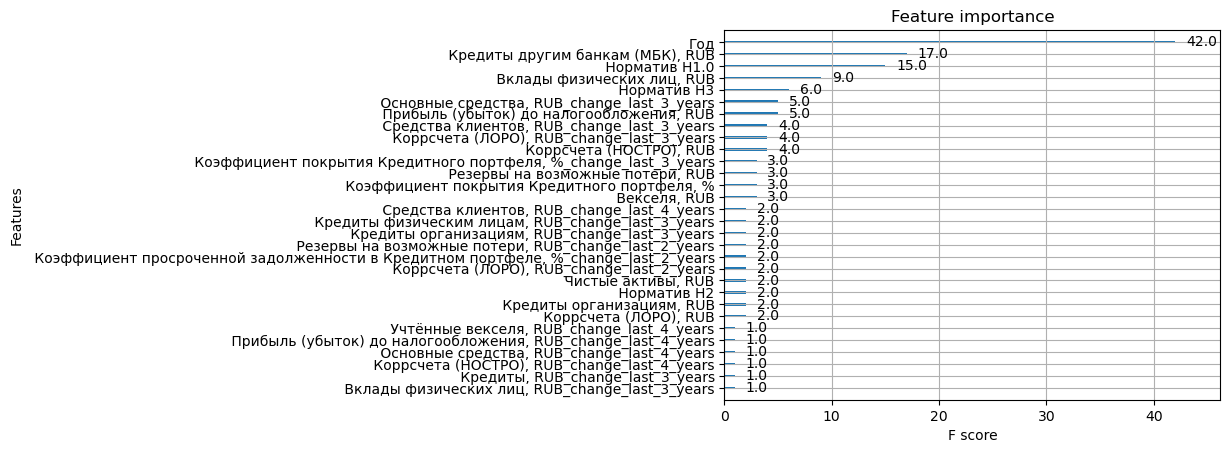

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

from matplotlib import pyplot as plt
import xgboost as xgb


xgb_params = {
    "max_depth": 4,
    "n_estimators": 1200,
    "learning_rate": 0.09479924808897194,
    "subsample": 1,
    "gamma": 0.4756674273309772,
    "min_child_weight": 0.23357425487768094,
    "max_delta_step": 0.7274545805862332,
    "colsample_bytree": 0.9893220571413148,
    "reg_alpha": 0.674401793402349,
    "reg_lambda": 0.4832264465328138,
    "scale_pos_weight": 1.1956253627044895
}

# Обучите модель XGBRegressor
xgb_regressor = xgb.XGBRegressor(**xgb_params)
xgb_regressor.fit(X_train, y_train)

# Сделайте предсказания на тестовом наборе
y_pred_xgb = xgb_regressor.predict(X_test)

# Вычислите метрики для XGBRegressor

print("Metrics for XGBoost:")
# Вычисление MAE
mae = mean_absolute_error(y_test, y_pred_xgb)
print(f"MAE: {mae}")

# Вычисление RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"RMSE: {rmse}")

# Вычисление R^2
r2 = r2_score(y_test, y_pred_xgb)
print(f"R^2: {r2}")
# Plot feature importance
xgb.plot_importance(xgb_regressor, max_num_features=30)
plt.show()


In [10]:
# Вычислите метрики для XGBClassifier
from sklearn.metrics import classification_report

# Округлите каждый элемент массива y_pred_xgb
y_pred_rounded = [round(pred) for pred in y_pred_xgb]

# Вычислите метрики классификации
classification_metrics = classification_report(y_test, y_pred_rounded)

print("Metrics for XGBoost:")
print(classification_metrics)


Metrics for XGBoost:
              precision    recall  f1-score   support

       False       0.90      0.99      0.94       100
        True       0.99      0.86      0.92        78

    accuracy                           0.93       178
   macro avg       0.94      0.92      0.93       178
weighted avg       0.94      0.93      0.93       178
